# ResNet50 Model | CIFAKE


In [35]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from keras.applications import ResNet50
from keras.optimizers import Adamax
from keras.regularizers import l1, l2
from keras.losses import BinaryCrossentropy
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping
from keras import Model
from utils import (
    load_data,
    plot_performance_curves,
    save_model_history,
    load_model_history,
)
import PIL

PIL.Image.MAX_IMAGE_PIXELS = None

In [36]:
model_name = "resnet50-regularized-adamax-noaug_model_ai-art"
dataset_base_path = "./datasets/AI art/"

# Forcefully train the model
force_model_train = False

# Don't save the model
no_save = False

In [37]:
# Load saved model and its history
model_history_loaded, classifier, history = load_model_history(model_name)

In [38]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(32, 32, 3), pooling='max')
base_model.trainable = True

In [39]:
# Building model
if not model_history_loaded or force_model_train:
    inputs = Input(shape=(32, 32, 3))
    x = base_model(inputs, training=False)
    x = BatchNormalization()(x)
    x = Dense(
        256,
        kernel_regularizer=l2(0.01),
        activity_regularizer=l1(0.01),
        bias_regularizer=l1(0.01),
        activation="relu",
    )(x)
    x = Dropout(rate=0.4)(x)
    x = Dense(64, activation="relu")(x)
    outputs = Dense(1, activation="sigmoid")(x)
    classifier = Model(inputs, outputs)

    classifier.compile(
            optimizer=Adamax(learning_rate=0.001),
            loss=BinaryCrossentropy(),
            metrics=['accuracy', Precision(), Recall()]
        )

In [40]:
# Model summary
classifier.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_3 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 256)               524544    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                           

In [41]:
# Load augmented image generators
train_generator, validation_generator = load_data(
    dataset_base_path, augmented=True, train_data_config={}, validation_data_config={}, batch_size=200
)

Found 17307 images belonging to 2 classes.
Found 4328 images belonging to 2 classes.


In [42]:
# Train model
if not model_history_loaded or force_model_train:
    history = classifier.fit(
        train_generator,
        epochs=100,
        validation_data=validation_generator,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
    )
    history = history.history

In [43]:
# Save model
if not model_history_loaded or (force_model_train and not no_save) or not no_save:
    save_model_history(classifier, history, model_name)

INFO:tensorflow:Assets written to: ./models/resnet50-regularized-adamax-noaug_model_ai-art/model\assets


INFO:tensorflow:Assets written to: ./models/resnet50-regularized-adamax-noaug_model_ai-art/model\assets


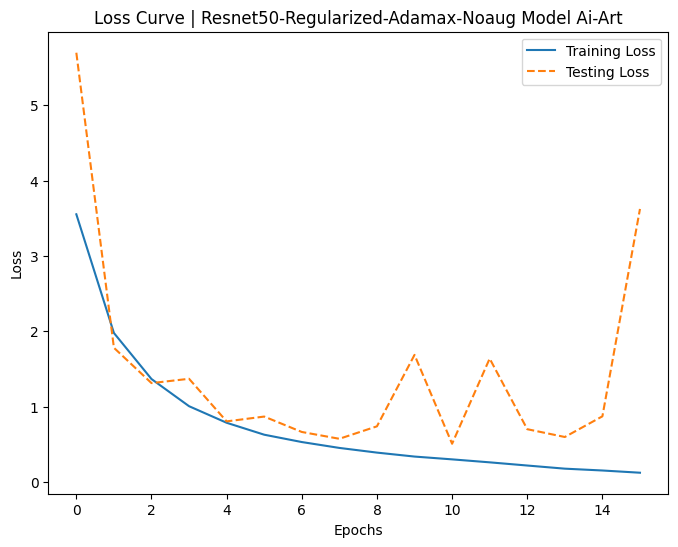

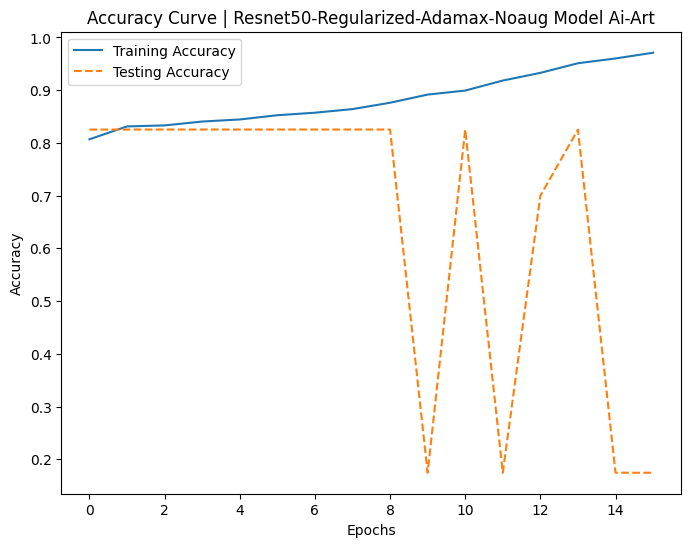

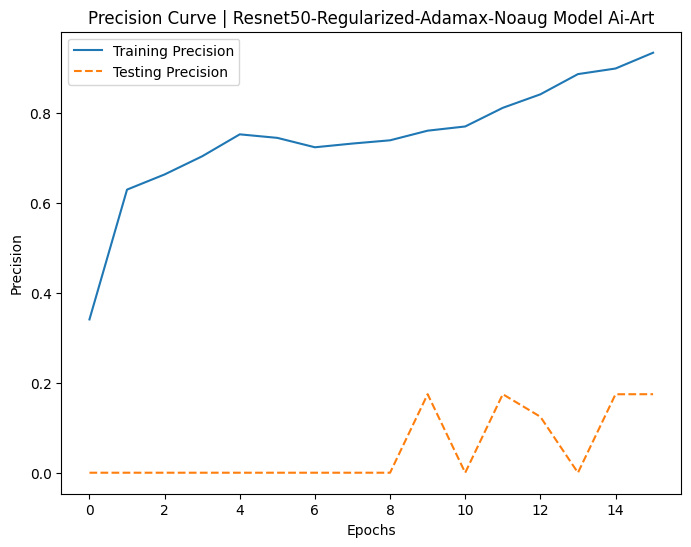

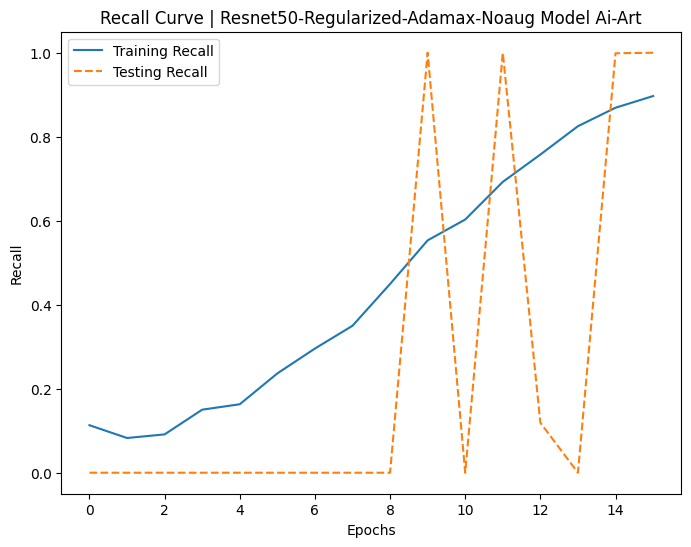

In [44]:
# Plot performance curves
plot_performance_curves(history, model_name)